In [13]:
import torch
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.models import SingleTaskGP
from botorch.models.model import Model
from botorch.optim import optimize_acqf
import warnings
import pickle
import os
os.sys.path.append('../')
from util.rollout import rollout
warnings.filterwarnings('ignore')

fontsize = 25

In [14]:
figsize = (6,5)
def plot_posterior(model: Model, x: Tensor, y: Tensor, ax=None, legend=False, fontsize=25, savepath=None):
    train_x = model.train_inputs[0]
    train_y = model.train_targets
    model.eval()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    with torch.no_grad():
        y_post = model(x)
        lower, upper = y_post.confidence_region()
        ax.plot(x.squeeze().numpy(), y.numpy(), '--r', label='true')
        ax.plot(train_x.squeeze().numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(x.squeeze().numpy(), y_post.mean.detach().numpy(), 'b', label='mean')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='CI')
        ax.set_ylim([-2.3, 2.3])
        for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
        if legend:
            ax.legend(fontsize=fontsize)

        for item in ([ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(fontsize)
        ax.axis('off')
        if savepath is not None:
            plt.savefig(savepath, bbox_inches='tight')

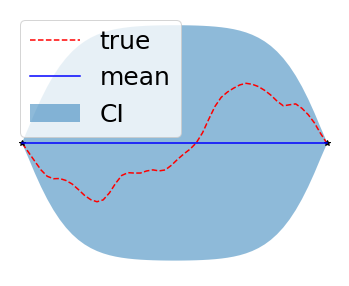

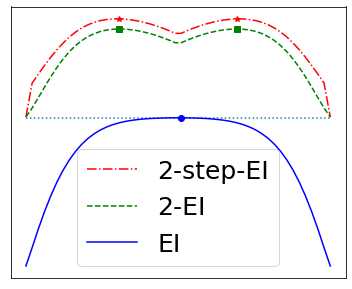

In [15]:
bound = 1
n = 50
x = torch.linspace(-bound, bound, n).view(-1, 1)
train_idx = [np.round(n / 3), np.round(n * 2 / 3)]
train_idx = [0, n-1]
train_x = x[train_idx]
train_y = Tensor([0, 0]).view(-1, 1)
model = SingleTaskGP(train_x, train_y)
model.covar_module.base_kernel.lengthscale = .4 #GammaPrior(alpha, beta).sample()
model.covar_module.outputscale = 1.
model.likelihood.noise = .0001
model.eval()

y_post = model(x)
torch.manual_seed(0)
y = y_post.sample()

y_best = torch.max(train_y).item()
# f, ax = plt.subplots(2, 1, figsize=(6, 8))
with torch.no_grad():
    plot_posterior(model, x, y, ax=None, legend=True, savepath='initial_state.pdf')

## compute EI
expected_improvement = ExpectedImprovement(model, best_f=y_best)
    
qmc_sampler = SobolQMCNormalSampler(num_samples=10000, seed=1)
qEI = qExpectedImprovement(model=model, best_f=y_best, sampler=qmc_sampler)
f, ax = plt.subplots(1, 1, figsize=figsize)


with torch.no_grad():
    two_step_ei_saved = 'intuition_bo.dat'
    try:
        with open(two_step_ei_saved, 'rb') as f:
            two_step_ei = pickle.load(f)
    except:
        num_y_samples = 100
        samples, weights = np.polynomial.hermite.hermgauss(num_y_samples)
        two_step_ei = np.zeros(n)

        for i in range(n):
            if i % (n/10) == 0: print(i)
            this_x = x[i]
            two_step_ei[i] = rollout(this_x, model,
                                    best_f=0.,
                                    bounds=Tensor([-bound, bound]).view(-1, 1),
                                    horizon=2,
                                    x_grid=x,
                                    idx=i,
                                    mode="grid-grid",
                                    quadrature=(samples, weights),
                                    num_y_samples=num_y_samples,
                                    )
            with open(two_step_ei_saved, 'wb') as f:
                pickle.dump(two_step_ei, f)
    idx = np.nonzero(np.max(two_step_ei) - two_step_ei < 9e-8)[0]
    alpha2step_ei = 1
    ax.plot(x.squeeze().numpy(), two_step_ei, 'r-.', label='2-step-EI', alpha=alpha2step_ei)
    ax.plot(x.squeeze().numpy()[idx], two_step_ei[idx], 'r*', alpha=alpha2step_ei)

    x2 = torch.cartesian_prod(x.squeeze(), x.squeeze()).t().unsqueeze(1).permute(2, 0, 1)
    two_ei_values = qEI(x2).view(n,n)
    two_ei_values = (two_ei_values + two_ei_values.t())/2.
    max_two_ei_values = torch.max(two_ei_values, dim=0)[0]
    alpha2ei = 1
    ax.plot(x.squeeze().numpy(), max_two_ei_values.numpy(), 'g--', label='2-EI', alpha=alpha2ei)

    idx = torch.nonzero( max(max_two_ei_values) == max_two_ei_values )
    ax.plot(x.squeeze().numpy()[idx], max_two_ei_values.numpy()[idx], 'sg', alpha=alpha2ei)

    ei_values = expected_improvement(x.unsqueeze(1))

    ei_max_idx = torch.argmax(ei_values)
    ax.plot(x.squeeze().numpy()[ei_max_idx], ei_values.numpy()[ei_max_idx], 'ob')
    ax.plot([-bound, bound], [ei_values.numpy()[ei_max_idx], ei_values.numpy()[ei_max_idx]], 
            ':',# label='max EI'
           )
    ax.plot(x.squeeze().numpy(), ei_values.numpy(), '-b', label='EI')



    ax.legend(fontsize=fontsize)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([0,.2,.4, .6])
    ax.yaxis.set_ticks([])
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
plt.savefig('ei_2ei_locations.pdf', bbox_inches='tight')

In [16]:
def ei_loop(model: Model, x: Tensor, y: Tensor, ax=None, budget=2, savepath=None):
    flag = False
    if savepath is None:
        flag = True
    for i in range(budget):
        x0 = model.train_inputs[0]
        y0 = model.train_targets
        y_best = torch.max(y0)
        expected_improvement = ExpectedImprovement(model, best_f=y_best)
        ei_values = expected_improvement(x.unsqueeze(1))
        idx = torch.argmax(ei_values)
        y1 = y[idx]
        
        train_x = torch.cat([x0, x[idx].unsqueeze(0)], -2)
        train_y = torch.cat([y0, y1.unsqueeze(0)])
        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        ax1 = ax if ax is None or budget == 1 else ax[i]
        if flag:
            savepath = f'ei_iter_{i+1}.pdf'
        plot_posterior(model, x, y, ax1, savepath=savepath)
    

def qei_loop(model: Model, x: Tensor, y: Tensor, ax=None,  seed=None):
    x0 = model.train_inputs[0]
    y0 = model.train_targets
    y_best = torch.max(y0)
    if seed is not None:
        torch.manual_seed(seed)
    qmc_sampler = SobolQMCNormalSampler(num_samples=10000,
                                        seed=seed)
    qEI = qExpectedImprovement(model=model, best_f=y_best, sampler=qmc_sampler)
    options = {"simple_init": True,
               "maxiter": 500,
               "seed": 0}
    two_ei_points, _ = joint_optimize(acq_function=qEI, 
                                   bounds=Tensor([-bound, bound]).view(-1,1),
                                   q=2,
                                   num_restarts=2,
                                   raw_samples=50,
                                   options=options,
                                  )
    expected_improvement = ExpectedImprovement(model, best_f=y_best)
    ei_of_two_ei_points = expected_improvement(two_ei_points.unsqueeze(1))
    best_idx = torch.argmax(ei_of_two_ei_points)
    idx = torch.argmin(torch.abs(x - two_ei_points[best_idx]))
    y1 = y[idx]
    train_x = torch.cat([x0, x[idx].unsqueeze(0)], -2)
    train_y = torch.cat([y0, y1.unsqueeze(0)])
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    savepath = 'qei_iter_1.pdf'
    ax1 = None if ax is None else ax[0]
    plot_posterior(model, x, y, ax1, savepath=savepath)
    ax2 = None if ax is None else ax[1]
    ei_loop(model, x, y, ax2, budget=1, savepath = 'qei_iter_2.pdf')

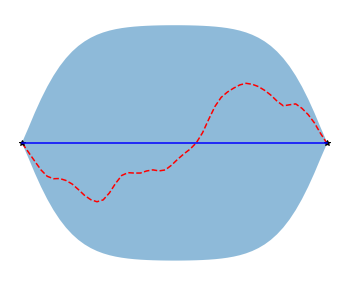

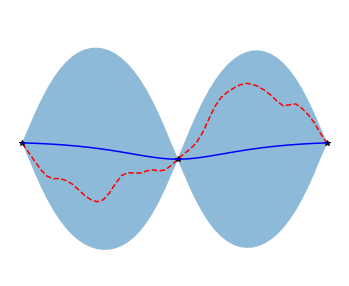

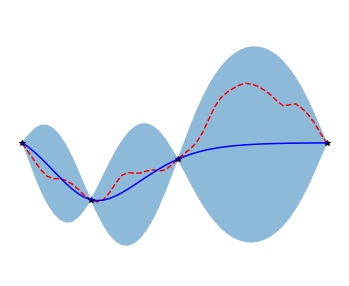

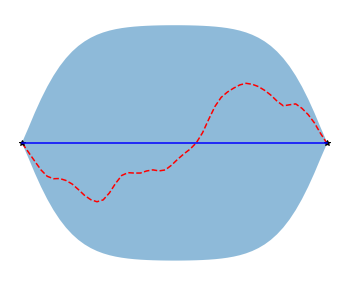

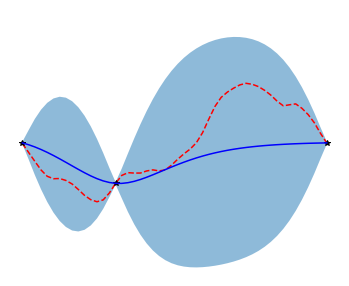

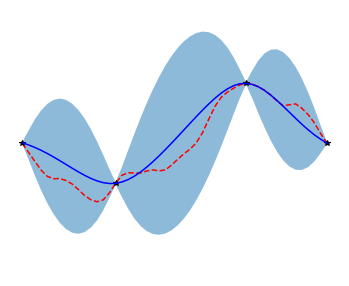

In [17]:
seed = 0
bound = 1
n = 50
x = torch.linspace(-bound, bound, n).view(-1, 1)
train_idx = [np.round(n / 3), np.round(n * 2 / 3)]
train_idx = [0, n-1]
train_x = x[train_idx]

model = SingleTaskGP(train_x, Tensor([0, 0]).view(-1, 1))
model.covar_module.base_kernel.lengthscale = .4 
model.covar_module.outputscale = 1.
model.likelihood.noise = .0001
model.eval()
y_post = model(x)

torch.manual_seed(seed)
y = y_post.sample()
train_y = y[train_idx]

# f, ax = plt.subplots(1, 3, figsize=(18, 4))
plot_posterior(model, x, y)
ei_loop(model, x, y, budget=2)
    
model = SingleTaskGP(train_x, Tensor([0, 0]).view(-1, 1))
model.covar_module.base_kernel.lengthscale = .4 
model.covar_module.outputscale = 1.
model.likelihood.noise = .0001
model.eval()
y_post = model(x)
torch.manual_seed(seed)
y = y_post.sample()
train_y = y[train_idx]

# f, ax = plt.subplots(1, 3, figsize=(18, 4))
plot_posterior(model, x, y)
qei_loop(model, x, y, seed=0)